In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import argparse
import subprocess
import os
from scipy.spatial import cKDTree
from netCDF4 import Dataset, default_fillvals
import xarray as xr

In [2]:
default_fillvals

{'S1': '\x00',
 'f4': 9.969209968386869e+36,
 'f8': 9.969209968386869e+36,
 'i1': -127,
 'i2': -32767,
 'i4': -2147483647,
 'i8': -9223372036854775806,
 'u1': 255,
 'u2': 65535,
 'u4': 4294967295,
 'u8': 18446744073709551614}

In [3]:
fillval_f = default_fillvals['f8']
fillval_i = default_fillvals['i4']

load 25km domain file

In [4]:
domain_25km_filename = 'domain.lnd.wr25b_ar9v4.170413.nc'
direc = '/Users/diana/Dropbox/UW/Research/rasm/25_km'
domain_25km = xr.open_dataset(os.path.join(direc, domain_25km_filename))
lon_25km = domain_25km['xc'].values
lat_25km = domain_25km['yc'].values
mask_25km = domain_25km['mask'].values

look at the mask and be sure it makes sense

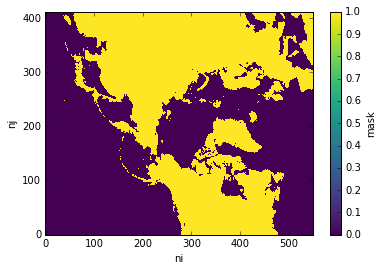

In [5]:
domain_25km['mask'].plot()

load 50km domain file

In [6]:
domain_50km_filename = 'domain.lnd.wr50a_ar9v4.100920.nc'
domain_50km = xr.open_dataset(os.path.join(direc, domain_50km_filename))
lon_50km = domain_50km['xc'].values
lat_50km = domain_50km['yc'].values
mask_50km = domain_50km['mask'].values

This is the function used for converting lat/lon to x, y, z: 

In [7]:
def lon_lat_to_cartesian(lon, lat, R = 1):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)

    return x, y, z

nearest neighbor interpolation with only land lats/lons

In [8]:
lat_25km_land = lat_25km[mask_25km > 0]
lon_25km_land = lon_25km[mask_25km > 0]
mask_25km_land = mask_25km[mask_25km > 0]
nj_inds_25km, ni_inds_25km = np.nonzero(mask_25km)

lat_50km_land = lat_50km[mask_50km > 0]
lon_50km_land = lon_50km[mask_50km > 0]
nj_inds_50km, ni_inds_50km = np.nonzero(mask_50km)

In [9]:
print(lat_25km_land.max())
print(lat_50km_land.max())

83.6407822419
83.6523202138


In [10]:
print(lat_25km_land.min())
print(lat_50km_land.min())

18.1974976742
21.8469808793


In [11]:
print(lon_25km_land.max())
print(lon_50km_land.max() - 180)

179.996896063
179.999809265


In [12]:
print(lon_25km_land.min())
print(lon_50km_land.min() - 180)

-179.955178535
-179.996505737


In [13]:
# lon, lat from coarser res data
xs, ys, zs = lon_lat_to_cartesian(lon_50km_land, lat_50km_land) 
# lon, lat from higher res data
xt, yt, zt = lon_lat_to_cartesian(lon_25km_land, lat_25km_land)

In [14]:
# build KD tree
zipped_50km = np.dstack(([xs, ys, zs]))[0]
tree = cKDTree(zipped_50km)

In [15]:
# find indices of the nearest neighbors in the flattened array 
zipped_25km = np.dstack(([xt, yt, zt]))[0]
d, inds = tree.query(zipped_25km, k=1)

In [167]:
# use indices to get 50km values for 25km grid
mask_50km_land = mask_50km[mask_50km > 0]
mask_nearest = mask_50km_land.flatten()[inds]

domain_25km['mask_interp'] = xr.DataArray(domain_25km['mask'].values)
domain_25km['mask_interp'].values[nj_inds_25km, ni_inds_25km] = mask_nearest 

load 50km parameters

In [168]:
ncparams_50km = 'vic_params_joe_copy.nc'
params_50km = xr.open_dataset(os.path.join(direc, ncparams_50km))

check to be sure that the mask isn't getting altered (it was before somehow) 

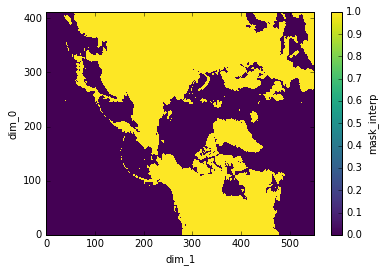

In [169]:
domain_25km['mask_interp'].plot()

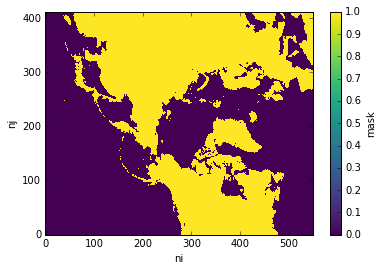

In [170]:
domain_25km.mask.plot()

In [258]:
params_50km.phi_s

<xarray.DataArray 'phi_s' (nlayer: 3, nj: 205, ni: 275)>
array([[[   nan,    nan, ...,    nan,    nan],
        [   nan,    nan, ...,    nan,    nan],
        ..., 
        [   nan,    nan, ..., -9999., -9999.],
        [   nan,    nan, ..., -9999., -9999.]],

       [[   nan,    nan, ...,    nan,    nan],
        [   nan,    nan, ...,    nan,    nan],
        ..., 
        [   nan,    nan, ..., -9999., -9999.],
        [   nan,    nan, ..., -9999., -9999.]],

       [[   nan,    nan, ...,    nan,    nan],
        [   nan,    nan, ...,    nan,    nan],
        ..., 
        [   nan,    nan, ..., -9999., -9999.],
        [   nan,    nan, ..., -9999., -9999.]]])
Coordinates:
    yc       (nj, ni) float64 16.53 16.78 17.02 17.27 17.51 17.76 18.0 18.25 ...
    xc       (nj, ni) float64 -170.8 -170.6 -170.4 -170.3 -170.1 -169.9 ...
Dimensions without coordinates: nlayer, nj, ni
Attributes:
    units:        mm/mm
    description:  Soil moisture diffusion parameter
    long_name:    phi_s

print domain file data variables

In [171]:
domain_25km.data_vars

Data variables:
    xv           (nj, ni, nv) float64 -170.6 -170.5 -170.6 -170.7 -170.5 ...
    yv           (nj, ni, nv) float64 16.15 16.27 16.35 16.23 16.27 16.4 ...
    mask         (nj, ni) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    area         (nj, ni) float64 6.398e-06 6.417e-06 6.437e-06 6.458e-06 ...
    frac         (nj, ni) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    mask_interp  (dim_0, dim_1) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...

print 50km parameter file data variables

In [172]:
params_50km.data_vars

Data variables:
    xv            (nv4, nj, ni) float64 189.3 189.4 189.2 189.0 189.4 189.6 ...
    yv            (nv4, nj, ni) float64 16.33 16.58 16.74 16.49 16.58 16.82 ...
    mask          (nj, ni) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    run_cell      (nj, ni) float64 nan nan nan nan nan nan nan nan nan nan ...
    gridcell      (nj, ni) float64 nan nan nan nan nan nan nan nan nan nan ...
    lats          (nj, ni) float64 nan nan nan nan nan nan nan nan nan nan ...
    lons          (nj, ni) float64 nan nan nan nan nan nan nan nan nan nan ...
    infilt        (nj, ni) float64 nan nan nan nan nan nan nan nan nan nan ...
    Ds            (nj, ni) float64 nan nan nan nan nan nan nan nan nan nan ...
    Dsmax         (nj, ni) float64 nan nan nan nan nan nan nan nan nan nan ...
    Ws            (nj, ni) float64 nan nan nan nan nan nan nan nan nan nan ...
    c             (nj, ni) float64 nan nan nan nan nan nan nan nan nan nan ...
    expt          (nlayer, nj, ni)

In [259]:
params_25km = xr.Dataset()

domain_25km = xr.open_dataset(os.path.join(direc, domain_25km_filename))

# define fillvals
fillval_f = default_fillvals['f8']
fillval_i = default_fillvals['i4']

# fill in data from the domain file

params_25km['run_cell'] = xr.DataArray(domain_25km['mask'].values, 
                                       dims=('nj', 'ni'),
                                       coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                       attrs={'units': "N/A", 'long_name': "run_cell"},
                                       encoding={"_FillValue": fillval_i,
                                                 "Coordinates": "xc yc",
                                                 "dtype": "int32"})

params_25km['mask'] = xr.DataArray(domain_25km['mask'].values,
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                   attrs={'description': "0 value indicates cell is not active", 
                                          'units': "N/A", 'long_name': "mask", 'bounds': 'yv'},
                                   encoding={"_FillValue": fillval_i,
                                                 "Coordinates": "xc yc",
                                                 "dtype": "int32"})

masknan_vals = params_25km['mask'].where(params_25km['mask'] == 1).values

# rename nv dimension to nv4 in 25km domain file (this is necessary for using it as a coordinate in the parameter file)
domain_25km = domain_25km.rename({'nv': 'nv4'})
params_25km['xv'] = xr.DataArray(np.rollaxis(domain_25km['xv'].values, axis=2),
                                 dims=('nv4', 'nj', 'ni'),
                                 attrs={'units': "degrees_east", 
                                        'long_name': "longitude of grid cell vertices"})

params_25km['yv'] = xr.DataArray(np.rollaxis(domain_25km['yv'].values, axis=2),
                                 dims=('nv4', 'nj', 'ni'),
                                 attrs={'units': "degrees_north", 
                                        'long_name': "latitude of grid cell vertices"})

# gridcell
gridcell_land = params_50km['gridcell'].values[mask_50km > 0]
nearest_gridcell = gridcell_land.flatten()[inds]
gridcell_vals = np.copy(masknan_vals)
params_25km['gridcell'] = xr.DataArray(gridcell_vals, 
                                       dims=('nj', 'ni'),
                                       coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                       attrs={'description': "Grid cell number", 
                                              'units': "N/A", 'long_name': "gridcell"},
                                       encoding={"_FillValue": fillval_i,
                                                 "Coordinates": "xc yc", "dtype": "int32"})
params_25km['gridcell'].values[nj_inds_25km, ni_inds_25km] = nearest_gridcell

# lats
lats_land = params_50km['lats'].values[mask_50km > 0]
nearest_lats = lats_land.flatten()[inds]
lats_vals = np.copy(masknan_vals)
params_25km['lats'] = xr.DataArray(lats_vals, 
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                   attrs={'description': "Latitude of grid cell", 
                                              'units': "degrees", 'long_name': "lats"})
params_25km['lats'].values[nj_inds_25km, ni_inds_25km] = nearest_lats

# lons
lons_land = params_50km['lons'].values[mask_50km > 0]
nearest_lons = lons_land.flatten()[inds]
lons_vals = np.copy(masknan_vals)
params_25km['lons'] = xr.DataArray(lons_vals,
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                   attrs={'description': "Longitude of grid cell", 
                                          'units': "degrees", 'long_name': "lons"})
params_25km['lons'].values[nj_inds_25km, ni_inds_25km] = nearest_lons

# infilt
infilt_land = params_50km['infilt'].values[mask_50km > 0]
nearest_infilt = infilt_land.flatten()[inds]
infilt_vals = np.copy(masknan_vals)
params_25km['infilt'] = xr.DataArray(infilt_vals,
                                     dims=('nj', 'ni'),
                                     coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                     attrs={'description': "Latitude of grid cell", 
                                            'units': "mm/day", 
                                            'long_name': "Variable infiltration curve parameter (binfilt)"},
                                     encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['infilt'].values[nj_inds_25km, ni_inds_25km] = nearest_infilt

# Ds
ds_land = params_50km['Ds'].values[mask_50km > 0]
nearest_ds = ds_land.flatten()[inds]
ds_vals = np.copy(masknan_vals)
params_25km['Ds'] = xr.DataArray(ds_vals,
                                 dims=('nj', 'ni'),
                                 coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                 attrs={'description': "Fraction of Dsmax where non-linear baseflow begins", 
                                         'units': "fraction", 'long_name': "Ds"},
                                 encoding={"_FillValue": fillval_f,
                                           "Coordinates": "xc yc"})
params_25km['Ds'].values[nj_inds_25km, ni_inds_25km] = nearest_ds

# Dsmax
dsmax_land = params_50km['Dsmax'].values[mask_50km > 0]
nearest_dsmax = dsmax_land.flatten()[inds]
dsmax_vals = np.copy(masknan_vals)
params_25km['Dsmax'] = xr.DataArray(dsmax_vals,
                                    dims=('nj', 'ni'),
                                    coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                    attrs={'description': "Maximum velocity of baseflow", 
                                              'units': "mm/day", 'long_name': "Dsmax"},
                                    encoding={"_FillValue": fillval_f,
                                              "Coordinates": "xc yc"})
params_25km['Dsmax'].values[nj_inds_25km, ni_inds_25km] = nearest_dsmax

# Ws
ws_land = params_50km['Ws'].values[mask_50km > 0]
nearest_ws = ws_land.flatten()[inds]
ws_vals = np.copy(masknan_vals)
params_25km['Ws'] = xr.DataArray(ws_vals,
                                 dims=('nj', 'ni'),
                                 coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                 attrs={'description': "Fraction of maximum soil moisture where non-linear baseflow occurs", 
                                              'units': "fraction", 'long_name': "Ws"},
                                 encoding={"_FillValue": fillval_f,
                                           "Coordinates": "xc yc"})
params_25km['Ws'].values[nj_inds_25km, ni_inds_25km] = nearest_ws

# c
c_land = params_50km['c'].values[mask_50km > 0]
nearest_c = c_land.flatten()[inds]
c_vals = np.copy(masknan_vals)
params_25km['c'] = xr.DataArray(c_vals,
                                dims=('nj', 'ni'),
                                coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                attrs={'description': "Exponent used in baseflow curve, normally set to 2", 
                                              'units': "N/A", 'long_name': "c"},
                                encoding={"_FillValue": fillval_f,
                                          "Coordinates": "xc yc"})
params_25km['c'].values[nj_inds_25km, ni_inds_25km] = nearest_c

# nlayer
params_25km['nlayer'] = xr.DataArray(params_50km.nlayer.values, dims='nlayer')

# array for 3d parameters
arr_nlayer = np.rollaxis(np.dstack((masknan_vals, masknan_vals, masknan_vals)), 
                        axis=2)

# expt
expt_land = params_50km['expt'].values[:, mask_50km > 0]
nearest_expt = expt_land.reshape(3, len(c_land))[:, inds]
expt_vals = np.copy(arr_nlayer)
params_25km['expt'] = xr.DataArray(expt_vals,
                                   dims=('nlayer','nj', 'ni'),
                                   coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                   attrs={'description': "Exponent n (=3+2/lambda) in Campbell's eqt for Ksat, HBH 5.6 \
                                           where lambda = soil pore size distribution parameter", 
                                           'units': "N/A", 'long_name': "expt"},
                                   encoding={"_FillValue": fillval_f,
                                             "Coordinates": "xc yc"})
params_25km['expt'].values[:, nj_inds_25km, ni_inds_25km] = nearest_expt

# Ksat
ksat_land = params_50km['Ksat'].values[:, mask_50km > 0]
nearest_ksat = ksat_land.reshape(3, len(c_land))[:, inds]
ksat_vals = np.copy(arr_nlayer)
params_25km['Ksat'] = xr.DataArray(ksat_vals, 
                                   dims=('nlayer','nj', 'ni'),
                                   coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                   attrs={'description': "Saturated hydraulic conductivity",
                                           'units': "mm/day", 'long_name': "Ksat"},
                                   encoding={"_FillValue": fillval_f,
                                             "Coordinates": "xc yc"})
params_25km['Ksat'].values[:, nj_inds_25km, ni_inds_25km] = nearest_ksat

# phi_s
phis_land = params_50km['phi_s'].values[:, mask_50km > 0]
nearest_phis = phis_land.reshape(3, len(c_land))[:, inds]
phis_vals = np.copy(arr_nlayer)
params_25km['phi_s'] = xr.DataArray(phis_vals,
                                    dims=('nlayer','nj', 'ni'),
                                    coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                    attrs={'description': "Soil moisture diffusion parameter",
                                           'units': "mm/mm", 'long_name': "phi_s"},
                                    encoding={"_FillValue": fillval_f,
                                              "Coordinates": "xc yc"})
params_25km['phi_s'].values[:, nj_inds_25km, ni_inds_25km] = nearest_phis

# init moist 
initmoist_land = params_50km['init_moist'].values[:, mask_50km > 0]
nearest_initmoist = initmoist_land.reshape(3, len(c_land))[:, inds]
initmoist_vals = np.copy(arr_nlayer)
params_25km['init_moist'] = xr.DataArray(initmoist_vals,
                                         dims=('nlayer','nj', 'ni'),
                                         coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                         attrs={'description': "Initial layer moisture content",
                                           'units': "mm", 'long_name': "init_moist"},
                                         encoding={"_FillValue": fillval_f,
                                                   "Coordinates": "xc yc"})
params_25km['init_moist'].values[:, nj_inds_25km, ni_inds_25km] = nearest_initmoist

# elev
elev_land = params_50km['elev'].values[mask_50km > 0]
nearest_elev = elev_land.flatten()[inds]
elev_vals = np.copy(masknan_vals)
params_25km['elev'] = xr.DataArray(elev_vals,
                                dims=('nj', 'ni'),
                                coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                attrs={'description': "Average elevation of grid cell", 
                                              'units': "m", 'long_name': "elev"},
                                encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['elev'].values[nj_inds_25km, ni_inds_25km] = nearest_elev

# depth
depth_land = params_50km['depth'].values[:, mask_50km > 0]
nearest_depth = depth_land.reshape(3, len(c_land))[:, inds]
depth_vals = np.copy(arr_nlayer)
params_25km['depth'] = xr.DataArray(depth_vals,
                                         dims=('nlayer','nj', 'ni'),
                                         coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                         attrs={'description': "Thickness of each soil moisture layer",
                                           'units': "m", 'long_name': "depth"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['depth'].values[:, nj_inds_25km, ni_inds_25km] = nearest_depth

# avg_T
avgt_land = params_50km['avg_T'].values[mask_50km > 0]
nearest_avgt = avgt_land.flatten()[inds]
avgt_vals = np.copy(masknan_vals)
params_25km['avg_T'] = xr.DataArray(avgt_vals,
                                dims=('nj', 'ni'),
                                coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                attrs={'description': "Average soil temperature, used as the bottom boundary \
                                        for soil heat flux solutions", 
                                        'units': "C", 'long_name': "avg_T"},
                                encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['avg_T'].values[nj_inds_25km, ni_inds_25km] = nearest_avgt

# dp
dp_land = params_50km['dp'].values[mask_50km > 0]
nearest_dp = dp_land.flatten()[inds]
dp_vals = np.copy(masknan_vals)
params_25km['dp'] = xr.DataArray(dp_vals,
                                dims=('nj', 'ni'),
                                coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                attrs={'description': "Soil thermal damping depth (depth at which soil temperature) \
                                        remains constant through the year, ~4 m", 
                                              'units': "m", 'long_name': "dp"},
                                encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['dp'].values[nj_inds_25km, ni_inds_25km] = nearest_dp

# bubble
bubble_land = params_50km['bubble'].values[:, mask_50km > 0]
nearest_bubble = bubble_land.reshape(3, len(c_land))[:, inds]
bubble_vals = np.copy(arr_nlayer)
params_25km['bubble'] = xr.DataArray(bubble_vals,
                                         dims=('nlayer','nj', 'ni'),
                                         coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                         attrs={'description': "Bubbling pressure of soil. Values should be > 0",
                                           'units': "cm", 'long_name': "bubble"},
                                encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['bubble'].values[:, nj_inds_25km, ni_inds_25km] = nearest_bubble

# quartz
quartz_land = params_50km['quartz'].values[:, mask_50km > 0]
nearest_quartz = quartz_land.reshape(3, len(c_land))[:, inds]
quartz_vals = np.copy(arr_nlayer)
params_25km['quartz'] = xr.DataArray(quartz_vals,
                                         dims=('nlayer','nj', 'ni'),
                                         coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                         attrs={'description': "Quartz content of soil",
                                           'units': "cm", 'long_name': "quartz"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['quartz'].values[:, nj_inds_25km, ni_inds_25km] = nearest_quartz

# bulk density
bd_land = params_50km['bulk_density'].values[:, mask_50km > 0]
nearest_bd = bd_land.reshape(3, len(c_land))[:, inds]
bd_vals = np.copy(arr_nlayer)
params_25km['bulk_density'] = xr.DataArray(bd_vals,
                                         dims=('nlayer','nj', 'ni'),
                                         coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                         attrs={'description': "Bulk density of soil layer",
                                           'units': "kg/m3", 'long_name': "bulk_density"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['bulk_density'].values[:, nj_inds_25km, ni_inds_25km] = nearest_bd

# soil density
sd_land = params_50km['soil_density'].values[:, mask_50km > 0]
nearest_sd = sd_land.reshape(3, len(c_land))[:, inds]
sd_vals = np.copy(arr_nlayer)
params_25km['soil_density'] = xr.DataArray(sd_vals,
                                         dims=('nlayer','nj', 'ni'),
                                         coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                         attrs={'description': "Soil particle density, normally 2685 kg/m3",
                                           'units': "kg/m3", 'long_name': "soil_density"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['soil_density'].values[:, nj_inds_25km, ni_inds_25km] = nearest_sd

# off_gmt
gmt_land = params_50km['off_gmt'].values[mask_50km > 0]
nearest_gmt = gmt_land.flatten()[inds]
gmt_vals = np.copy(masknan_vals)
params_25km['off_gmt'] = xr.DataArray(gmt_vals,
                                dims=('nj', 'ni'),
                                coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                attrs={'description': "Time zone offset from GMT. This parameter determines how \
                                        VIC interprets sub-daily time steps relative to the model start date and time.", 
                                        'units': "hours", 'long_name': "off_gmt"},
                                encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['off_gmt'].values[nj_inds_25km, ni_inds_25km] = nearest_gmt

# Wcr_FRACT
wcr_land = params_50km['Wcr_FRACT'].values[:, mask_50km > 0]
nearest_wcr = wcr_land.reshape(3, len(c_land))[:, inds]
wcr_vals = np.copy(arr_nlayer)
params_25km['Wcr_FRACT'] = xr.DataArray(wcr_vals,
                                         dims=('nlayer','nj', 'ni'),
                                         coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                         attrs={'description': "Fractional soil moisture content at the critical point \
                                                (~70%% of field capacity) (fraction of maximum moisture)",
                                           'units': "fraction", 'long_name': "Wcr_FRACT"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['Wcr_FRACT'].values[:, nj_inds_25km, ni_inds_25km] = nearest_wcr

# Wpwp_FRACT
wp_land = params_50km['Wpwp_FRACT'].values[:, mask_50km > 0]
nearest_wp = wp_land.reshape(3, len(c_land))[:, inds]
wp_vals = np.copy(arr_nlayer)
params_25km['Wpwp_FRACT'] = xr.DataArray(wp_vals,
                                         dims=('nlayer','nj', 'ni'),
                                         coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                         attrs={'description': "Fractional soil moisture content at the \
                                                wilting point (fraction of maximum moisture)",
                                           'units': "fraction", 'long_name': "Wpwp_FRACT"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['Wpwp_FRACT'].values[:, nj_inds_25km, ni_inds_25km] = nearest_wp

# rough
rough_land = params_50km['rough'].values[mask_50km > 0]
nearest_rough = rough_land.flatten()[inds]
rough_vals = np.copy(masknan_vals)
params_25km['rough'] = xr.DataArray(rough_vals,
                                dims=('nj', 'ni'),
                                coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                attrs={'description': "Surface roughness of bare soil", 
                                              'units': "m", 'long_name': "rough"},
                                encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['rough'].values[nj_inds_25km, ni_inds_25km] = nearest_rough

# snow rough
snowrough_land = params_50km['snow_rough'].values[mask_50km > 0]
nearest_snowrough = snowrough_land.flatten()[inds]
snowrough_vals = np.copy(masknan_vals)
params_25km['snow_rough'] = xr.DataArray(snowrough_vals,
                                dims=('nj', 'ni'),
                                coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                attrs={'description': "Surface roughness of snowpack", 
                                              'units': "m", 'long_name': "snow_rough"},
                                encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['snow_rough'].values[nj_inds_25km, ni_inds_25km] = nearest_snowrough

# annual prec
prec_land = params_50km['annual_prec'].values[mask_50km > 0]
nearest_prec = prec_land.flatten()[inds]
prec_vals = np.copy(masknan_vals)
params_25km['annual_prec'] = xr.DataArray(prec_vals,
                                dims=('nj', 'ni'),
                                coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                attrs={'description': "Average annual precipitation", 
                                              'units': "mm", 'long_name': "annual_prec"},
                                encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['annual_prec'].values[nj_inds_25km, ni_inds_25km] = nearest_prec

# resid moist
resid_land = params_50km['resid_moist'].values[:, mask_50km > 0]
nearest_resid = resid_land.reshape(3, len(c_land))[:, inds]
resid_vals = np.copy(arr_nlayer)
params_25km['resid_moist'] = xr.DataArray(resid_vals,
                                         dims=('nlayer','nj', 'ni'),
                                         coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                         attrs={'description': "Soil moisture layer residual moisture",
                                           'units': "fraction", 'long_name': "resid_moist"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['resid_moist'].values[:, nj_inds_25km, ni_inds_25km] = nearest_resid

# fs_active
fs_land = params_50km['fs_active'].values[mask_50km > 0]
nearest_fs = fs_land.flatten()[inds]
fs_vals = np.copy(masknan_vals)
params_25km['fs_active'] = xr.DataArray(fs_vals,
                                dims=('nj', 'ni'),
                                coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                attrs={'description': "If set to 1, then frozen soil algorithm is activated for the \
                                        grid cell. A 0 indicates that frozen soils are not computed if soil \
                                        temperatures fall below 0C.", 
                                        'units': "binary", 'long_name': "fs_active"},
                                encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})
params_25km['fs_active'].values[nj_inds_25km, ni_inds_25km] = nearest_fs

# cellnum
cellnum_land = params_50km['cellnum'].values[mask_50km > 0]
nearest_cellnum = cellnum_land.flatten()[inds]
cellnum_vals = np.copy(masknan_vals)
params_25km['cellnum'] = xr.DataArray(cellnum_vals,
                                dims=('nj', 'ni'),
                                coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                attrs={'description': "Grid cell number (should match numbers assigned in \
                                        soil parameter file)", 
                                        'units': "N/A", 'long_name': "cellnum"},
                                encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})
params_25km['cellnum'].values[nj_inds_25km, ni_inds_25km] = nearest_cellnum

# array for parameters with snow bands
arr_snowband = np.rollaxis(np.dstack((masknan_vals, masknan_vals, masknan_vals, masknan_vals, masknan_vals)), 
                           axis=2)
# snow_band
params_25km['snow_band'] = xr.DataArray(params_50km.snow_band.values, dims='snow_band')

# AreaFract
areafract_land = params_50km['AreaFract'].values[:, mask_50km > 0]
nearest_areafract = areafract_land.reshape(5, len(c_land))[:, inds]
areafract_vals = np.copy(arr_snowband)
params_25km['AreaFract'] = xr.DataArray(areafract_vals,
                                         dims=('snow_band','nj', 'ni'),
                                         coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                         attrs={'description': "Fraction of grid cell covered by each elevation band. \
                                                Sum of the fractions must equal 1.",
                                                'units': "fraction", 'long_name': "AreaFract"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['AreaFract'].values[:, nj_inds_25km, ni_inds_25km] = nearest_areafract

# elevation
elevation_land = params_50km['elevation'].values[:, mask_50km > 0]
nearest_elevation = elevation_land.reshape(5, len(c_land))[:, inds]
elevation_vals = np.copy(arr_snowband)
params_25km['elevation'] = xr.DataArray(elevation_vals,
                                         dims=('snow_band','nj', 'ni'),
                                         coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                         attrs={'description': "Mean (or median) elevation of elevation band. This is \
                                                 used to compute the change in air temperature from the grid cell \
                                                 mean elevation",
                                                'units': "m", 'long_name': "elevation"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['elevation'].values[:, nj_inds_25km, ni_inds_25km] = nearest_elevation

# Pfactor
pfactor_land = params_50km['Pfactor'].values[:, mask_50km > 0]
nearest_pfactor = pfactor_land.reshape(5, len(c_land))[:, inds]
pfactor_vals = np.copy(arr_snowband)
params_25km['Pfactor'] = xr.DataArray(pfactor_vals,
                                         dims=('snow_band','nj', 'ni'),
                                         coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                         attrs={'description': "Fraction of cell precipitation that falls on each \
                                                elevation band. Total must equal 1. To ignore effects of elevation \
                                                on precipitation, set these fractions equal to the area fractions.",
                                                'units': "fraction", 'long_name': "Pfactor"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['Pfactor'].values[:, nj_inds_25km, ni_inds_25km] = nearest_pfactor

# month
# array for parameters with months
arr_months = np.rollaxis(np.dstack((masknan_vals, masknan_vals, masknan_vals, masknan_vals, masknan_vals, masknan_vals,
                                    masknan_vals, masknan_vals, masknan_vals, masknan_vals, masknan_vals, masknan_vals)), 
                        axis=2)
params_25km['month'] = xr.DataArray(params_50km.month.values, dims='month', 
                                    attrs={'long_name': "month of year"})

# veg class
# array for parameters with veg classes
arr_veg_classes = np.rollaxis(np.dstack((masknan_vals, masknan_vals, masknan_vals, masknan_vals, masknan_vals, masknan_vals,
                                    masknan_vals, masknan_vals, masknan_vals, masknan_vals, masknan_vals, masknan_vals)), 
                              axis=2)
params_25km['veg_class'] = xr.DataArray(params_50km.veg_class.values, dims='veg_class', 
                                    attrs={'long_name': "vegetation class"})

# Nveg
nveg_land = params_50km['Nveg'].values[mask_50km > 0]
nearest_nveg = nveg_land.flatten()[inds]
nveg_vals = np.copy(masknan_vals)
params_25km['Nveg'] = xr.DataArray(nveg_vals,
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                   attrs={'description': "Number of vegetation tiles in the grid cell", 
                                          'units': "N/A", 'long_name': "Nveg"},
                                   encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})
params_25km['Nveg'].values[nj_inds_25km, ni_inds_25km] = nearest_nveg

# Cv
cv_land = params_50km['Cv'].values[:, mask_50km > 0]
nearest_cv = cv_land.reshape(12, len(c_land))[:, inds]
cv_vals = np.copy(arr_veg_classes)
params_25km['Cv'] = xr.DataArray(cv_vals,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                 attrs={'description': "Fraction of grid cell covered by vegetation tile",
                                        'units': "fraction", 'long_name': "Cv"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['Cv'].values[:, nj_inds_25km, ni_inds_25km] = nearest_cv

# veg class and root zone
# 4-d array (veg_class, root_zone, nj, ni)
arr_veg_classes_rootzone = np.vstack((arr_nlayer, arr_nlayer, arr_nlayer, arr_nlayer, arr_nlayer, arr_nlayer,
                                      arr_nlayer, arr_nlayer, arr_nlayer, arr_nlayer, 
                                      arr_nlayer, arr_nlayer)).reshape(12, 3, 413, 551)

params_25km['root_zone'] = xr.DataArray(params_50km.root_zone.values, dims='root_zone', 
                                    attrs={'long_name': "root zone"})

# root depth
rootd_land = params_50km['root_depth'].values[:, :, mask_50km > 0]
nearest_rootd = rootd_land.reshape(12, 3, len(c_land))[:, :, inds]
rootd_vals = np.copy(arr_veg_classes_rootzone)
params_25km['root_depth'] = xr.DataArray(rootd_vals,
                                         dims=('veg_class','root_zone','nj', 'ni'),
                                         coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                         attrs={'description': "Root zone thickness (sum of depths is total depth of \
                                                 root penetration)",
                                                'units': "m", 'long_name': "root_depth"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['root_depth'].values[:, :, nj_inds_25km, ni_inds_25km] = nearest_rootd

# root fract
rootfract_land = params_50km['root_fract'].values[:, :, mask_50km > 0]
nearest_rootfract = rootfract_land.reshape(12, 3, len(c_land))[:, :, inds]
rootfract_vals = np.copy(arr_veg_classes_rootzone)
params_25km['root_fract'] = xr.DataArray(rootfract_vals,
                                         dims=('veg_class','root_zone','nj', 'ni'),
                                         coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                         attrs={'description': "Fraction of root in the current root zone",
                                                'units': "fraction", 'long_name': "root_fract"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['root_fract'].values[:, :, nj_inds_25km, ni_inds_25km] = nearest_rootfract

# veg class and month
# 4-d array (veg_class, month, nj, ni)
arr_veg_classes_month = np.vstack((arr_months, arr_months, arr_months, arr_months, arr_months, arr_months,
                                      arr_months, arr_months, arr_months, arr_months, 
                                      arr_months, arr_months)).reshape(12, 12, 413, 551)

# LAI 
lai_land = params_50km['LAI'].values[:, :, mask_50km > 0]
nearest_lai = lai_land.reshape(12, 12, len(c_land))[:, :, inds]
lai_vals = np.copy(arr_veg_classes_month)
params_25km['LAI'] = xr.DataArray(lai_vals,
                                 dims=('veg_class','month','nj', 'ni'),
                                 coords={'xc': domain_25km.xc, 'yc': domain_25km.yc, 'month': params_25km.month},
                                 attrs={'description': "Leaf Area Index, one per month",
                                        'units': "N/A", 'long_name': "LAI"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['LAI'].values[:, :, nj_inds_25km, ni_inds_25km] = nearest_lai

# overstory
overstory_land = params_50km['overstory'].values[:, mask_50km > 0]
nearest_overstory = overstory_land.reshape(12, len(c_land))[:, inds]
overstory_vals = np.copy(arr_veg_classes)
params_25km['overstory'] = xr.DataArray(overstory_vals,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                 attrs={'description': "Flag to indicate whether or not the current vegetation type \
                                        has an overstory (TRUE for overstory present (e.g. trees), FALSE for \
                                        overstory not present (e.g. grass))",
                                        'units': "N/A", 'long_name': "overstory"},
                                 encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})
params_25km['overstory'].values[:, nj_inds_25km, ni_inds_25km] = nearest_overstory

# rarc
rarc_land = params_50km['rarc'].values[:, mask_50km > 0]
nearest_rarc = rarc_land.reshape(12, len(c_land))[:, inds]
rarc_vals = np.copy(arr_veg_classes)
params_25km['rarc'] = xr.DataArray(rarc_vals,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                 attrs={'description': "Architectural resistance of vegetation type (~2 s/m)",
                                        'units': "s/m", 'long_name': "rarc"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['rarc'].values[:, nj_inds_25km, ni_inds_25km] = nearest_rarc

# rmin
rmin_land = params_50km['rmin'].values[:, mask_50km > 0]
nearest_rmin = rmin_land.reshape(12, len(c_land))[:, inds]
rmin_vals = np.copy(arr_veg_classes)
params_25km['rmin'] = xr.DataArray(rmin_vals,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                 attrs={'description': "Minimum stomatal resistance of vegetation type (~100 s/m)",
                                        'units': "s/m", 'long_name': "rmin"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['rmin'].values[:, nj_inds_25km, ni_inds_25km] = nearest_rmin

# windh
windh_land = params_50km['wind_h'].values[:, mask_50km > 0]
nearest_windh = windh_land.reshape(12, len(c_land))[:, inds]
windh_vals = np.copy(arr_veg_classes)
params_25km['wind_h'] = xr.DataArray(windh_vals,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                 attrs={'description': "Height at which wind speed is measured",
                                        'units': "m", 'long_name': "wind_h"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['wind_h'].values[:, nj_inds_25km, ni_inds_25km] = nearest_windh

# RGL
rgl_land = params_50km['RGL'].values[:, mask_50km > 0]
nearest_rgl = rgl_land.reshape(12, len(c_land))[:, inds]
rgl_vals = np.copy(arr_veg_classes)
params_25km['RGL'] = xr.DataArray(rgl_vals,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                 attrs={'description': "Minimum incoming shortwave radiation at which there will be \
                                        transpiration. For trees this is about 30 W/m^2, for crops about 100 W/m^2",
                                        'units': "W/m^2", 'long_name': "RGL"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['RGL'].values[:, nj_inds_25km, ni_inds_25km] = nearest_rgl

# rad_atten
rad_land = params_50km['rad_atten'].values[:, mask_50km > 0]
nearest_rad = rad_land.reshape(12, len(c_land))[:, inds]
rad_vals = np.copy(arr_veg_classes)
params_25km['rad_atten'] = xr.DataArray(rad_vals,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                 attrs={'description': "Radiation attenuation factor. Normally set to 0.5, though may \
                                        need to be adjusted for high latitudes",
                                        'units': "fraction", 'long_name': "rad_atten"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['rad_atten'].values[:, nj_inds_25km, ni_inds_25km] = nearest_rad

# wind_atten
wind_land = params_50km['wind_atten'].values[:, mask_50km > 0]
nearest_wind = wind_land.reshape(12, len(c_land))[:, inds]
wind_vals = np.copy(arr_veg_classes)
params_25km['wind_atten'] = xr.DataArray(wind_vals,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                 attrs={'description': "Wind speed attenuation through the overstory. The default value \
                                        has been 0.5",
                                        'units': "fraction", 'long_name': "wind_atten"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['wind_atten'].values[:, nj_inds_25km, ni_inds_25km] = nearest_wind

# trunk ratio
trunk_land = params_50km['trunk_ratio'].values[:, mask_50km > 0]
nearest_trunk = trunk_land.reshape(12, len(c_land))[:, inds]
trunk_vals = np.copy(arr_veg_classes)
params_25km['trunk_ratio'] = xr.DataArray(trunk_vals,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                 attrs={'description': "Ratio of total tree height htat is trunk (no branches) \
                                        The default value has been 0.2",
                                        'units': "fraction", 'long_name': "Cv"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['trunk_ratio'].values[:, nj_inds_25km, ni_inds_25km] = nearest_trunk

# snow albedo
snowalb_land = params_50km['snow_albedo'].values[:, mask_50km > 0]
nearest_snowalb = snowalb_land.reshape(12, len(c_land))[:, inds]
snowalb_vals = np.copy(arr_veg_classes)
params_25km['snow_albedo'] = xr.DataArray(snowalb_vals,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                 attrs={'description': "Maximum vegetation snow albedo",
                                        'units': "fraction", 'long_name': "snow_albedo"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['snow_albedo'].values[:, nj_inds_25km, ni_inds_25km] = nearest_snowalb

# albedo
albedo_land = params_50km['albedo'].values[:, :, mask_50km > 0]
nearest_albedo = albedo_land.reshape(12, 12, len(c_land))[:, :, inds]
albedo_vals = np.copy(arr_veg_classes_month)
params_25km['albedo'] = xr.DataArray(albedo_vals,
                                         dims=('veg_class','month','nj', 'ni'),
                                         coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                         attrs={'description': "Shortwave albedo for vegetation type",
                                                'units': "fraction", 'long_name': "albedo"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['albedo'].values[:, :, nj_inds_25km, ni_inds_25km] = nearest_albedo

# veg_rough 
vegrough_land = params_50km['veg_rough'].values[:, :, mask_50km > 0]
nearest_vegrough = vegrough_land.reshape(12, 12, len(c_land))[:, :, inds]
vegrough_vals = np.copy(arr_veg_classes_month)
params_25km['veg_rough'] = xr.DataArray(vegrough_vals,
                                         dims=('veg_class','month','nj', 'ni'),
                                         coords={'xc': domain_25km.xc, 'yc': domain_25km.yc},
                                         attrs={'description': "Vegetation roughness length (typically 0.123 \
                                                * vegetation height)",
                                                'units': "m", 'long_name': "veg_rough"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['veg_rough'].values[:, :, nj_inds_25km, ni_inds_25km] = nearest_vegrough

# displacement
disp_land = params_50km['displacement'].values[:, :, mask_50km > 0]
nearest_disp = disp_land.reshape(12, 12, len(c_land))[:, :, inds]
disp_vals = np.copy(arr_veg_classes_month)
params_25km['displacement'] = xr.DataArray(disp_vals,
                                         dims=('veg_class','month','nj', 'ni'),
                                         coords={'month': params_25km['month'], 'xc': domain_25km.xc, 
                                                 'yc': domain_25km.yc},
                                         attrs={'description': "Vegetation displacement height (typically 0.67 \
                                                * vegetation height)",
                                                'units': "m", 'long_name': "displacement"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params_25km['displacement'].values[:, :, nj_inds_25km, ni_inds_25km] = nearest_disp

params_25km['xc'] = xr.DataArray(domain_25km['xc'].values,
                                 dims=('nj', 'ni'),
                                 attrs={'units': "degrees_east", 'long_name': "longitude of gridcell center",
                                        'bounds': 'xv'})

params_25km['yc'] = xr.DataArray(domain_25km['yc'].values,
                                 dims=('nj', 'ni'),
                                 attrs={'units': "degrees_north", 'long_name': "latitude of gridcell center",
                                        'bounds': 'yv'})

In [260]:
params_25km.run_cell.encoding

{'Coordinates': 'xc yc', '_FillValue': -2147483647, 'dtype': 'int32'}

In [261]:
params_50km.displacement

<xarray.DataArray 'displacement' (veg_class: 12, month: 12, nj: 205, ni: 275)>
array([[[[  nan, ...,   nan],
         ..., 
         [  nan, ...,  8.04]],

        ..., 
        [[  nan, ...,   nan],
         ..., 
         [  nan, ...,  8.04]]],


       ..., 
       [[[  nan, ...,   nan],
         ..., 
         [  nan, ...,  0.  ]],

        ..., 
        [[  nan, ...,   nan],
         ..., 
         [  nan, ...,  0.  ]]]])
Coordinates:
    yc       (nj, ni) float64 16.53 16.78 17.02 17.27 17.51 17.76 18.0 18.25 ...
    xc       (nj, ni) float64 -170.8 -170.6 -170.4 -170.3 -170.1 -169.9 ...
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: veg_class, nj, ni
Attributes:
    long_name:    displacement
    units:        m
    description:  Vegetation displacement height (typically 0.67 * vegetation...

In [262]:
params_25km.to_netcdf('params_25km_full.nc', format='NETCDF4_CLASSIC')

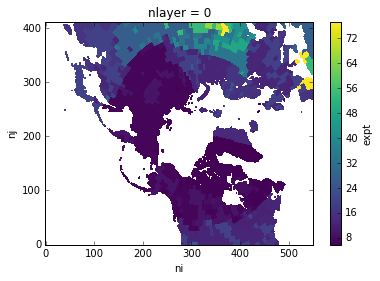

In [263]:
params_25km.expt.isel(nlayer=0).plot()

In [62]:
arr_3d = np.ones(shape=(3, domain_25km.mask.values.shape[0], domain_25km.mask.values.shape[1]))
domain_25km['arr_3d'] = xr.DataArray(arr_3d)

In [151]:
domain_25km = domain_25km.rename({'nv': 'nv4'})
domain_25km

<xarray.Dataset>
Dimensions:      (dim_0: 413, dim_1: 551, ni: 551, nj: 413, nv4: 4)
Coordinates:
    xc           (nj, ni) float64 -170.6 -170.5 -170.4 -170.4 -170.3 -170.2 ...
    yc           (nj, ni) float64 16.25 16.38 16.5 16.62 16.74 16.86 16.98 ...
Dimensions without coordinates: dim_0, dim_1, ni, nj, nv4
Data variables:
    xv           (nj, ni, nv4) float64 -170.6 -170.5 -170.6 -170.7 -170.5 ...
    yv           (nj, ni, nv4) float64 16.15 16.27 16.35 16.23 16.27 16.4 ...
    mask         (nj, ni) int32 -2147483648 -2147483648 -2147483648 ...
    area         (nj, ni) float64 6.398e-06 6.417e-06 6.437e-06 6.458e-06 ...
    frac         (nj, ni) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    mask_interp  (dim_0, dim_1) int32 -2147483648 -2147483648 -2147483648 ...
Attributes:
    title:               CESM domain data:
    Conventions:         CF-1.0
    source_code:         SVN $Id: gen_domain.F90 41914 2012-11-13 21:58:37Z m...
    SVN_url:              $URL: https:/

In [134]:
np.rollaxis(domain_25km.xv.values, axis=2).shape

(4, 413, 551)

In [98]:
params_50km.veg_class.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])